# Operator inference

In this example, we will identify an unknown operator describing a physical system by
combining tools from scientific computing (PDEs, discretizations) and machine learning
(minimizing prediction errors, backpropagation).

For this, the [Julia](https://julialang.org/) language is a natural choice,
in this example because of automatic differentiation (AD) of native code.

## The Julia bootstrap block (for Google Colab)
Source: https://colab.research.google.com/drive/1_4Yz3FKO5_uuYvamEfHqwtFT9WpCuSbm

This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
so that colab will redirect to the installed Julia kernel
and then doing your own work

In [ ]:
# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm

# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia"; using IJulia; installkernel("Julia")'

# 3. hot-fix patch to strip the version suffix of the installed kernel so
# that this notebook kernelspec is version agnostic
#!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [ ]:
using Pkg; Pkg.add(["OrdinaryDiffEq", "DiffEqFlux", "Plots"])

We start by loading some packages.

In [1]:
using LinearAlgebra
using SparseArrays
using OrdinaryDiffEq
using DiffEqFlux
using Plots

That may have taken some time. Julia is a compiled language, and she won't
hesitate to compile any code she can put her eyes on, even just to get a
small specialization improvement. Once heavy simulations are launched,
however, this efficiency will be worth your patience. The first time you run
some of the cells below it may also take some time, as the functions, say,
`heatmap`, specializes on your input types. Once a function is compiled
however, it should stay so for the remainder of the session.

Since the problems will consist of inferring various matrices, we define a small helper
function for visualizing our results:

In [2]:
plotmat(A; kwargs...) = heatmap(
    reverse(A; dims = 1);
    aspect_ratio = :equal,
    xlims = (1 / 2, size(A, 2) + 1 / 2),
    ylims = (1 / 2, size(A, 1) + 1 / 2),
    # xticks = nothing,
    # yticks = nothing,
    kwargs...,
)

plotmat (generic function with 1 method)

We also provide a specialized method for sparse matrices, which must be densified before
plotting.

In [3]:
plotmat(A::AbstractSparseMatrix; kwargs...) = plotmat(Matrix(A); kwargs...)

plotmat (generic function with 2 methods)

## Problem statement

Consider a linear ordinary differential equation (ODE) parameterized by some operator
$\mathbf{A}$:

$$\frac{\mathrm{d} \mathbf{u}}{\mathrm{d} t} = \mathbf{A} \mathbf{u}, \quad \mathbf{u}(0)
= \mathbf{u}_0$$

where $\mathbf{u}_0$ are some initial conditions. To solve this system, we will use the
[OrdinaryDiffEq](https://github.com/SciML/OrdinaryDiffEq.jl) package. It provides
differentiable ODE solvers for problems defined by a parametrized ODE function $f$
defining the right hand side of the ODE for a given state $\mathbf{u}$, time $t$ and
parameters $p$ (in our case: $p = \mathbf{A}$), i.e. $\frac{\mathrm{d}
\mathbf{u}}{\mathrm{d} t} = f(\mathbf{u}, p, t)$.

In [4]:
f(u, A, t) = A * u

f (generic function with 1 method)

For convenience, we will define a solver function $\mathbf{S}: (\mathbf{A}, \mathbf{u}_0,
t) \mapsto \mathbf{u}(t)$, where $\mathbf{u}$ is the solution to the above system for a
given operator $\mathbf{A}$ and initial conditions $\mathbf{u}_0$. The method `Tsit5`
is a fourth order Runge Kutta method.

In [5]:
?Tsit5

search: Tsit5 AutoTsit5 TsitPap8 AutoSwitch startswith methodswith



```
Tsit5(; stage_limiter! = OrdinaryDiffEq.trivial_limiter!,
        step_limiter! = OrdinaryDiffEq.trivial_limiter!,
        thread = OrdinaryDiffEq.False())
```

A fourth-order, five-stage explicit Runge-Kutta method with embedded error estimator of Tsitouras. Free 4th order interpolant.

Like SSPRK methods, this method also takes optional arguments `stage_limiter!` and `step_limiter!`, where `stage_limiter!` and `step_limiter!` are functions of the form `limiter!(u, integrator, p, t)`.

The argument `thread` determines whether internal broadcasting on appropriate CPU arrays should be serial (`thread = OrdinaryDiffEq.False()`, default) or use multiple threads (`thread = OrdinaryDiffEq.True()`) when Julia is started with multiple threads.

## References

@article{tsitouras2011runge,   title={Runge–Kutta pairs of order 5 (4) satisfying only the first column simplifying assumption},   author={Tsitouras, Ch},   journal={Computers \& Mathematics with Applications},   volume={62},   number={2},   pages={770–775},   year={2011},   publisher={Elsevier} }


In [6]:
function S(A, u₀, t)
    problem = ODEProblem(ODEFunction(f), u₀, (0.0, t[end]), A)
    solve(problem, Tsit5(); saveat = t)
end

S (generic function with 1 method)

Consider now the diffusion equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in
\Omega = [0, 1]$$

with diffusivity $\kappa > 0$, homogeneous Dirichlet boundary conditions $u(0, t) = u(1,
t) = 0$, and initial conditions $u(x, 0) = u_0(x)$.

In [7]:
κ = 0.005
a = 0.0
b = 1.0
L = b - a

1

The domain $\Omega$ may be discretized using a uniform grid $\mathbf{x} = (x_n)_{0 \leq n
\leq N}$ of $N + 1$ equidistant points. We will also make a refined grid `xfine` for
plotting.

In [8]:
xfine = LinRange(a, b, 1001)
N = 50
x = LinRange(a, b, N + 1)
Δx = L / N

0.02

On the above grid, the diffusion operator $\frac{\partial^2}{\partial x^2}$ with constant
Dirichlet boundary conditions may be approximated using the matrix

$$\mathbf{D} = \frac{1}{\Delta x^2} \begin{pmatrix}
    0 &  \dots &  \dots &  \dots & 0 \\
    1 &     -2 &      1 &        &   \\
      & \ddots & \ddots & \ddots &   \\
      &        &      1 &     -2 & 1 \\
    0 &  \dots &  \dots &  \dots & 0 \\
\end{pmatrix}.$$

This approximation is second order accurate:

$$(\mathbf{D} \mathbf{u})_n = \frac{\partial^2 u}{\partial x^2}(x_n) + \mathcal{O}(\Delta
x^2).$$

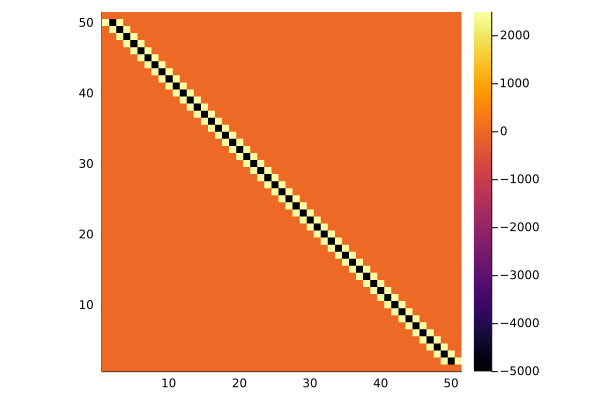

In [9]:
D = 1 / Δx^2 * spdiagm(-1 => fill(1.0, N), 0 => fill(-2.0, N + 1), 1 => fill(1.0, N))
D[1, :] .= 0 # Do not change first value
D[end, :] .= 0 # Do not change last value
plotmat(D)

The semi-discrete solution $t \mapsto \mathbf{u}(t) = (u(x_n, t))_n \in \mathbb{R}^{N +
1}$ may be approximated using the solver $\mathbf{S}$:

$$\mathbf{u}(t) \approx \mathbf{S}(\kappa \mathbf{D}, u_0(\mathbf{x}), t),$$

i.e. we set $\mathbf{A} = \kappa \mathbf{D}$ in the ODE.

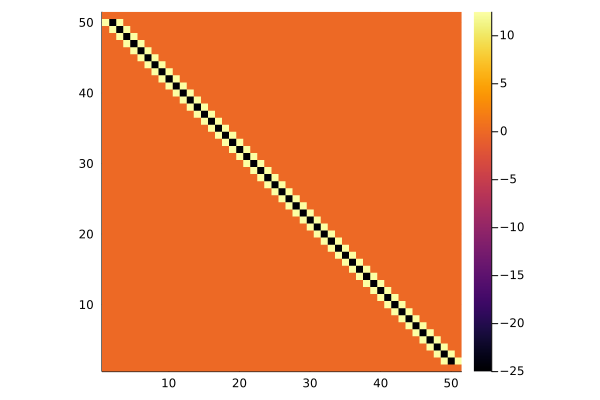

In [10]:
A_ref = κ * D
plotmat(A_ref)

The diffusion operator $\frac{\partial^2}{\partial x^2}$ with homogeneous boundary
conditions on $\Omega$ admit an eigenfunction basis $(X_k)_{k \in \mathbb{N}^*}$ with

$$X_k(x) = \sqrt{\frac{2}{L}} \sin \left( \frac{\pi k x}{L} \right).$$

The associated eigenvalues are given by $\lambda_k = -\frac{\pi^2 k^2}{L^2}$. Since these
functions form a basis of $L^2(\Omega)$, all solutions to the diffusion equation with
homogeneous boundary conditions may be written on the form

$$u(x, t) = \sum_{k \in \mathbb{N}^*} c_k \exp \left( - \kappa \frac{\pi^2 k^2}{L^2}
t \right) X_k(x),$$

where the coefficients $(c_k)_{k \in \mathbb{N}^*}$ are determined by projecting the
initial conditions onto the (orthogonal) eigenfunction basis:

$$c_k = \int_\Omega u_0(x) X_k(x) \, \mathrm{d} x.$$

In particular, we may use this formulation to generate exact solutions to the diffusion
equation, by providing arbitrary coefficients. These solutions may used as training data
for identifying the "unknown" discrete diffusion operator $\mathbf{A}$ (of which a very
promising second-order accurate candidate is given by $\mathbf{A}_\text{ref} = \kappa
\mathbf{D}$).

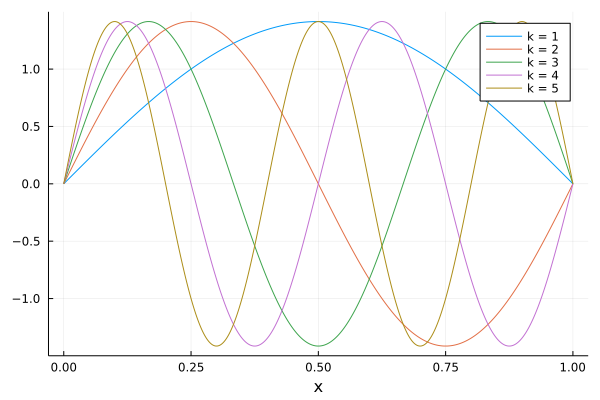

In [13]:
X(k, x) = √(2 / L) * sin(π * k * (x - a) / L)
p = plot(; xlabel = "x")
for k = 1:5
    plot!(p, xfine, X.(k, xfine); label = "k = $k")
end
p

In [14]:
function create_solution(c, k)
    u(x, t) = sum(c * exp(-κ * (π * k / L)^2 * t) * X(k, x) for (c, k) in zip(c, k))
    ∂u∂t(x, t) =
        -sum(
            c * κ * (π * k / L)^2 * exp(-κ * (π * k / L)^2 * t) * X(k, x) for
            (c, k) ∈ zip(c, k)
        )
    u, ∂u∂t
end

create_solution (generic function with 1 method)

A particular solution is given below, containing three different frequencies. We may use
this solution to test our solver, from now on referred to as the *full order model* (FOM).

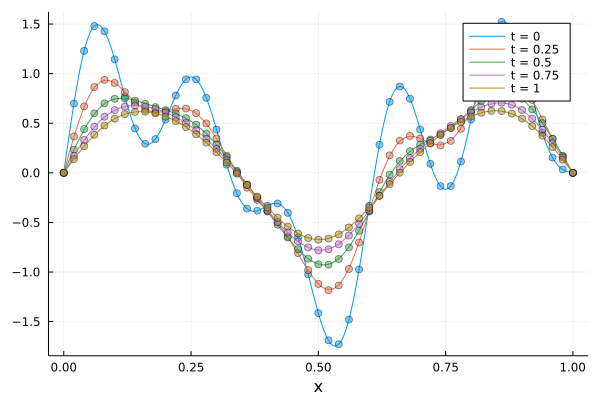

In [17]:
k = [3, 7, 10]
c = [0.7, 0.3, 0.4]
u, ∂u∂t = create_solution(c, k)
p = plot(; xlabel = "x");
tplot = LinRange(0.0, 1.0, 5)
sol = S(A_ref, u.(x, 0.0), tplot)
for (i, t) ∈ enumerate(tplot)
    plot!(p, xfine, u.(xfine, t); label = "t = $t", color = i) # Exact
    scatter!(p, x, sol[i]; label = nothing, markeralpha = 0.5, color = i) # FOM
end
p

## Learning the operator intrusively

Before inferring the unknown operator, we need som "training" data to compare
with. This will consist of snapshots of different initial conditions diffused
for different durations. We will sample normally distributed random
coefficients decaying with the frequency $k$, and put the results in a
snapshot tensor of size $N \times n_\text{sample} \times n_t$.

In [18]:
tsnap = LinRange(0.0, 1.0, 51)[2:end]
nsample = 200
K = 50
k = 1:K
c = [randn(K) ./ k for _ = 1:nsample]
solutions = [create_solution(c, k) for c ∈ c]
u = [s[1] for s ∈ solutions]
∂u∂t = [s[2] for s ∈ solutions]
init = [u(x, 0.0) for x ∈ x, u ∈ u]
train = [u(x, t) for x ∈ x, u ∈ u, t ∈ tsnap]
∂train∂t = [∂u∂t(x, t) for x ∈ x, ∂u∂t ∈ ∂u∂t, t ∈ tsnap]

51×200×50 Array{Float64, 3}:
[:, :, 1] =
 -0          -0          -0          …  -0          -0          -0
 13.91       -9.359       6.394         -0.3234     -4.173      -0.5368
  0.7898     -3.689       0.9419        -2.806       1.231      -4.525
 -5.784      11.61        1.828         -1.538       2.964      -2.922
 -5.059      -0.5364     -2.057          0.3262      0.7876     -0.9174
  3.948      -6.319      -5.4        …   3.773      -8.279       4.484
  0.1554     -1.476      -2.332         -7.049       1.911       5.614
 -0.7104     -1.796       2.138         -2.279       1.726      -4.603
  1.921       4.137       3.113          2.5        -1.573      -0.7747
  2.633       8.713       5.928          4.216       1.431       0.2959
  2.674      -4.747       0.5583     …   5.558       1.899       1.211
  2.608      -3.529      -4.498         -3.484       0.6427     -0.444
 -3.153      -2.257      -2.386         -0.06445    -0.6369      6.327
  ⋮                                 

We also need an instantaneous performance metric (loss/cost/objective
function). This function should compare our predictions with a snapshots of
the exact solutions. Here we will use a simple $L^2$-distance (mean squared
error). Note that the `ODESolution` object behaves like an array of size $N
\times n_\text{sample} \times n_t$, meaning that we solve for all the
different initial conditions at the same time.

In [19]:
loss(A, u₀, uₜ, t) = sum(abs2, S(A, u₀, t) - uₜ) / prod(size(uₜ))
loss(A) = loss(A, init, train, tsnap)

loss (generic function with 2 methods)

As an initial guess for the "unknown" operator $\mathbf{A}$ we will simply
use an empty matrix.

In [20]:
A = zeros(N + 1, N + 1)

51×51 Matrix{Float64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

We may also visualize the performance of our operator.

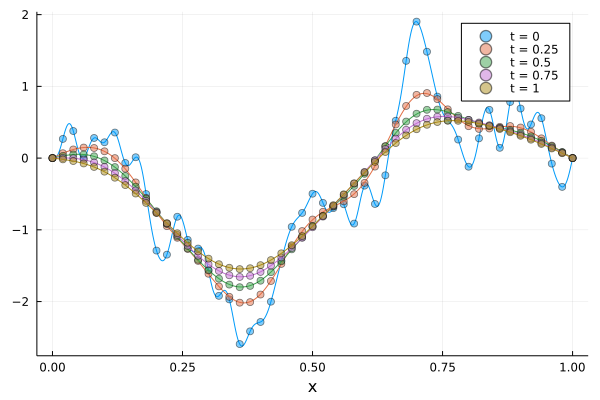

In [21]:
function ploterr(A, u, tplot = LinRange(0.0, 1.0, 5))
    sol = S(A, u.(x, 0.0), tplot)
    p = plot(; xlabel = "x")
    for (i, t) ∈ enumerate(tplot)
        plot!(p, xfine, u.(xfine, t); color = i, label = nothing)
        scatter!(p, x, sol[i]; label = "t = $t", color = i, markeralpha = 0.5)
    end
    p
end
ploterr(A_ref, u[6])

A callback function is called after every iteration of gradient descent, allowing us to
check the performance of our operator in real time during training. The return value
`false` simply stops the function from stopping the iterations. We can already check how
our initial guess for $\mathbf{A}$ performs.

You may choose any of the callbacks below. For Jupyter notebooks, the two
first options will print a plot after every iteration, which will quickly become very
verbose. You may want to add a counter, plotting only every 10th itereation or so, or use
the less verbose third callback option.

0.1314


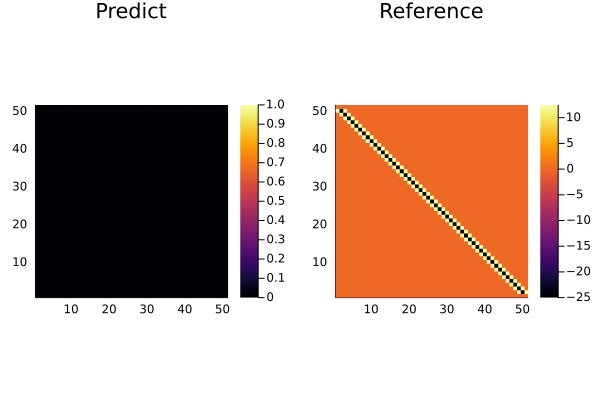

false

In [22]:
function callback(A, loss)
    println(loss)
    flush(stdout)
    display(
        plot(
            plotmat(A; title = "Predict"),
            plotmat(A_ref; title = "Reference");
            layout = (1, 2),
        ),
    )
    false
end
callback(A, loss(A))

0.1314


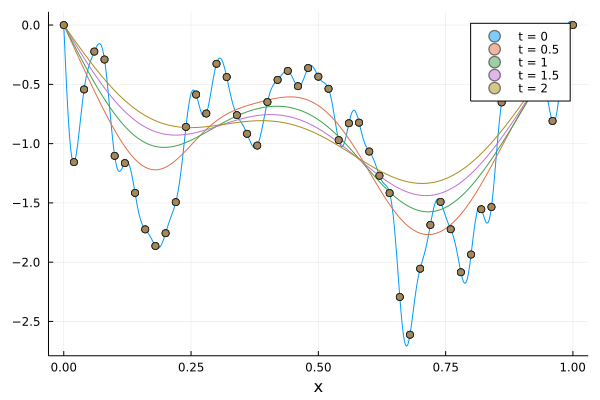

false

In [23]:
function callback(A, loss)
    println(loss)
    flush(stdout)
    display(ploterr(A, u[1], LinRange(0.0, 2.0, 5)))
    false
end
callback(A, loss(A))

In [24]:
callback(A, loss) = (println(loss);
flush(stdout);
false)
callback(A, loss(A))

0.1314


false

The intrusive training consists of improving the operator through gradient
descent applied to the loss function. The optimizer
[`ADAM`](https://arxiv.org/abs/1412.6980) performs a first order gradient
descent, but with some sophisiticated momentum terms exploiting the
stochasticity of the loss function. For larger problems we could could use a
subset of the different solutions $u$, time steps $t$ and spatial points $x$
at every evaluation of `loss`, but for now we will just use the entire
dataset.

0.1314
0.1356
0.1177
0.1139
0.109
0.1016
0.09582
0.09244
0.08993
0.08703
0.08356
0.08016
0.07762
0.07593
0.0742
0.07204
0.06987
0.06814
0.06674
0.06545
0.06412
0.06274
0.06142
0.06025
0.0592
0.05813
0.05708
0.05615
0.05529
0.05441
0.05349
0.05264
0.05189
0.05122
0.05054
0.04983
0.04914
0.04849
0.04789
0.04734
0.04679
0.04622
0.04566
0.04514
0.04466
0.04419
0.04372
0.04326
0.04281
0.04238
0.04196
0.04156
0.04117
0.04078
0.0404
0.04004
0.03968
0.03933
0.03899
0.03866
0.03833
0.03802
0.0377
0.0374
0.0371
0.03681
0.03652
0.03624
0.03597
0.0357
0.03544
0.03518
0.03492
0.03467
0.03443
0.03419
0.03395
0.03372
0.03349
0.03326
0.03304
0.03282
0.03261
0.0324
0.03219
0.03198
0.03178
0.03158
0.03139
0.03119
0.031
0.03082
0.03063
0.03045
0.03027
0.03009
0.02992
0.02975
0.02958
0.02941
0.02924
0.02908
0.02892
0.02876
0.0286
0.02844
0.02829
0.02814
0.02799
0.02784
0.02769
0.02755
0.0274
0.02726
0.02712
0.02698
0.02684
0.02671
0.02657
0.02644
0.02631
0.02618
0.02605
0.02593
0.0258
0.02568
0.02555
0.02

0.005338
0.005333
0.005328
0.005323
0.005318
0.005314
0.005309
0.005304
0.0053
0.005295
0.00529
0.005286
0.005281
0.005277
0.005272
0.005267
0.005263
0.005258
0.005253
0.005249
0.005244
0.00524
0.005235
0.005231
0.005231


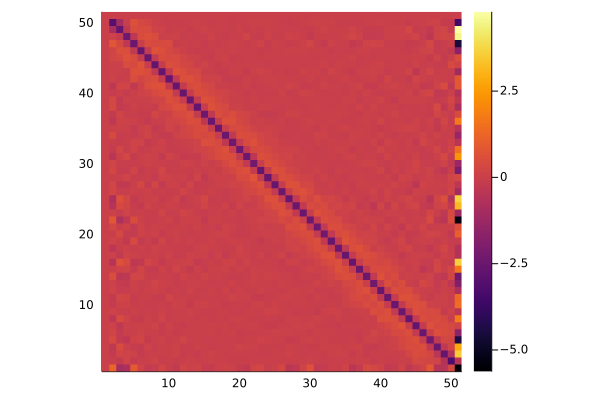

In [25]:
result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = 1000)
Afit = result.u
plotmat(Afit)

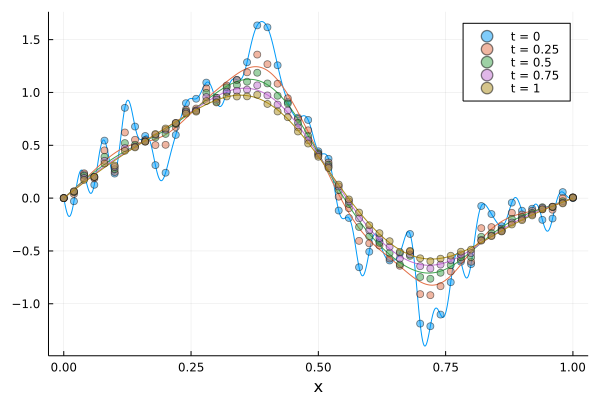

In [26]:
ploterr(Afit, u[4])

Notice that at no point did we explicitly specify the gradient of `loss`, `S`
or even `f` with respect to the matrix `A`. Yet still we performed a gradient
descent. Since the entire computational graph is composed of pure Julia code,
automatic differentiation engines, in this particular case
[Zygote](https://github.com/FluxML/Zygote.jl), can use the chain rule to
compute gradients. We may access this gradient explicitly. Let us check for
the initial guess first:

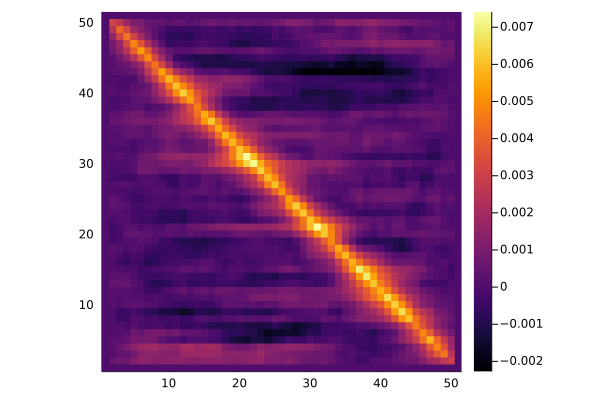

In [27]:
∂L∂A = first(Zygote.gradient(loss, A))
plotmat(∂L∂A)

and for the final result:

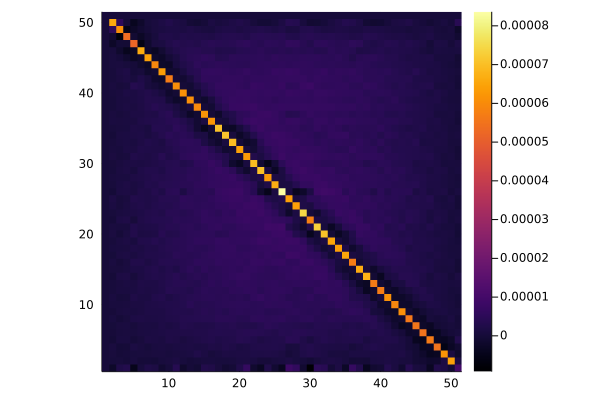

In [28]:
∂L∂Afit = first(Zygote.gradient(loss, Afit))
plotmat(∂L∂Afit)

The gradient of the fitted operator is indeed much closer to zero (indicating
a possible minimum):

In [29]:
norm(∂L∂A)

0.07831

In [30]:
norm(∂L∂Afit)

0.000481

Note also that the optimizer used here is [ADAM](https://arxiv.org/abs/1412.6980), which
is typically used to train neural networks. In fact, our ODE solver is not so different
from a neural network. Here we used a 4/5 Runge Kutta solver, but consider for
illustrative purposes a simple forward Euler scheme $\frac{\mathbf{u}^{n+1} -
\mathbf{u}^n}{\Delta t} = \mathbf{A} \mathbf{u}^n$. It satisfies the definition of a
"vanilla" neural network:

| Neural network | ODE |
| :------------: | :-: |
| $$\mathbf{x} \to \left[ \operatorname{NN}_\theta \right] \to \mathbf{y}$$ | $$\mathbf{u}_0
\to \left[ \frac{\mathrm{d} \mathbf{u}}{\mathrm{d} t} = \mathbf{A} \mathbf{u} \right] \to
\mathbf{u}(T)$$ |
| $$\mathbf{h}_0 = \mathbf{x}$$ | $$\mathbf{u}_0 = \mathbf{u}_0$$ |
| $$\mathbf{h}_{k + 1} = \sigma_k(\mathbf{W}_k \mathbf{h}_k +
\mathbf{b}_k)$$ | $$\mathbf{u}_{k + 1} = (\mathbf{I} + \Delta t_k \mathbf{A})
\mathbf{u}_k$$ |
| $$\mathbf{y} = \mathbf{h}_K$$ | $$\mathbf{u}(T) = \mathbf{u}_K$$ |
| $$\underset{\theta}{\min} \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal P} \|
\mathbf{y}_\theta(\mathbf{x}) - \mathbf{y} \|^2$$ | $$\underset{\mathbf{A}}{\min}
\mathbb{E}_{\mathbf{u} \sim \mathcal{U}} \| \mathbf{u}_\mathbf{A}(T) - \mathbf{u}(T)
\|^2$$ |



### Adding a regularization

We may also try out different loss functions. Since the resulting matrix from the above
fit is quite dense, we could maybe enforce sparsity by adding penalization jump for going
from zero to non-zero coefficients.

0.1314
0.1357
0.1181
0.1136
0.1093
0.1015
0.09575
0.09258
0.09012
0.08718
0.08371
0.08033
0.07781
0.07617
0.07446
0.07229
0.07014
0.06844
0.06706
0.06576
0.06443
0.06309
0.0618
0.06064
0.05955
0.05849
0.05748
0.05657
0.0557
0.05482
0.05392
0.05309
0.05235
0.05167
0.05099
0.0503
0.04963
0.04898
0.04839
0.04783
0.04729
0.04674
0.04618
0.04567
0.04519
0.04473
0.04427
0.04381
0.04337
0.04294
0.04253
0.04214
0.04175
0.04136
0.04099
0.04063
0.04028
0.03993
0.0396
0.03927
0.03895
0.03863
0.03833
0.03803
0.03773
0.03744
0.03716
0.03689
0.03661
0.03635
0.03609
0.03583
0.03558
0.03534
0.03509
0.03486
0.03462
0.03439
0.03417
0.03395
0.03373
0.03352
0.0333
0.0331
0.03289
0.03269
0.03249
0.0323
0.03211
0.03192
0.03173
0.03155
0.03137
0.03119
0.03101
0.03084
0.03067
0.0305
0.03033
0.03017
0.03001
0.02985
0.02969
0.02953
0.02938
0.02923
0.02908
0.02893
0.02878
0.02864
0.02849
0.02835
0.02821
0.02807
0.02794
0.0278
0.02767
0.02754
0.02741
0.02728
0.02715
0.02703
0.0269
0.02678
0.02666
0.02654
0.02642


0.006922
0.006922
0.006923
0.006927
0.00693
0.006939
0.006945
0.006959
0.006966
0.006981
0.00698
0.006987
0.00697
0.006957
0.006922


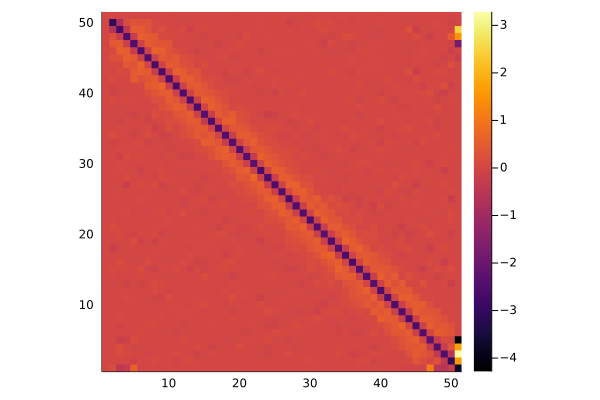

In [31]:
ℓ₁loss(A) = loss(A) + 1e-2 * sum(abs, A) / prod(size(A))
result = DiffEqFlux.sciml_train(ℓ₁loss, A, ADAM(0.01); cb = callback, maxiters = 1000)
A_ℓ₁ = result.u
plotmat(A_ℓ₁)

0.1314
0.1356
0.1177
0.1139
0.109
0.1016
0.09582
0.09244
0.08994
0.08704
0.08357
0.08017
0.07763
0.07595
0.07422
0.07206
0.0699
0.06816
0.06677
0.06548
0.06415
0.06277
0.06146
0.06029
0.05924
0.05817
0.05713
0.05619
0.05534
0.05446
0.05355
0.05269
0.05195
0.05128
0.0506
0.0499
0.04921
0.04856
0.04797
0.04741
0.04686
0.04629
0.04574
0.04522
0.04474
0.04427
0.04381
0.04335
0.0429
0.04247
0.04206
0.04166
0.04127
0.04088
0.04051
0.04015
0.03979
0.03944
0.03911
0.03878
0.03845
0.03814
0.03783
0.03753
0.03723
0.03694
0.03666
0.03638
0.03611
0.03584
0.03558
0.03532
0.03507
0.03482
0.03458
0.03434
0.03411
0.03388
0.03365
0.03343
0.03321
0.03299
0.03278
0.03257
0.03237
0.03216
0.03196
0.03177
0.03157
0.03138
0.0312
0.03101
0.03083
0.03065
0.03047
0.0303
0.03013
0.02996
0.02979
0.02962
0.02946
0.0293
0.02914
0.02898
0.02883
0.02867
0.02852
0.02837
0.02823
0.02808
0.02794
0.02779
0.02765
0.02751
0.02738
0.02724
0.02711
0.02697
0.02684
0.02671
0.02658
0.02646
0.02633
0.02621
0.02608
0.02596
0.0258

0.007507
0.007611
0.007623
0.007663
0.007537
0.007422
0.007291
0.007237
0.007263
0.007326
0.007387
0.007373
0.007329
0.007257
0.007217
0.007222
0.007253
0.007217


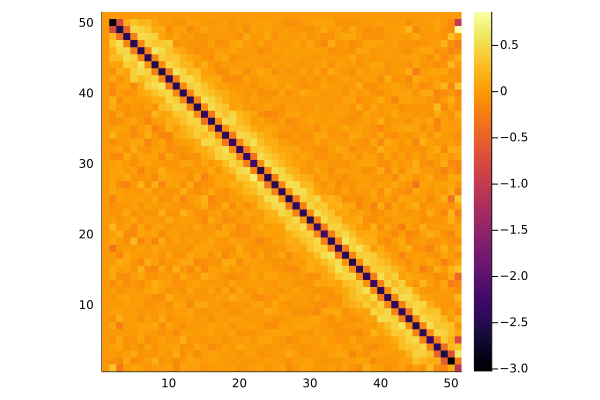

In [32]:
ℓ₂loss(A) = loss(A) + 1e-2 * sum(abs2, A) / prod(size(A))
result = DiffEqFlux.sciml_train(ℓ₂loss, A, ADAM(0.01); cb = callback, maxiters = 1000)
A_ℓ₂ = result.u
plotmat(A_ℓ₂)

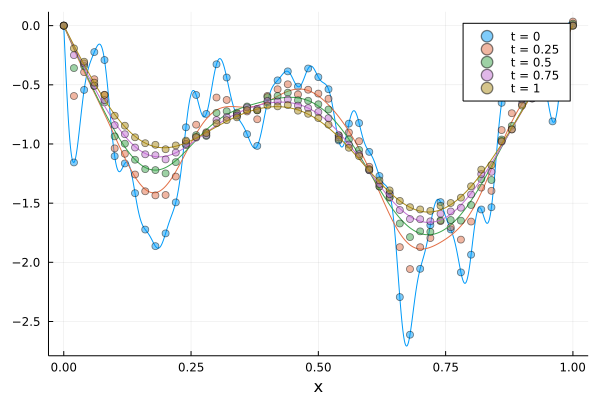

In [33]:
ploterr(A_ℓ₁, u[1])

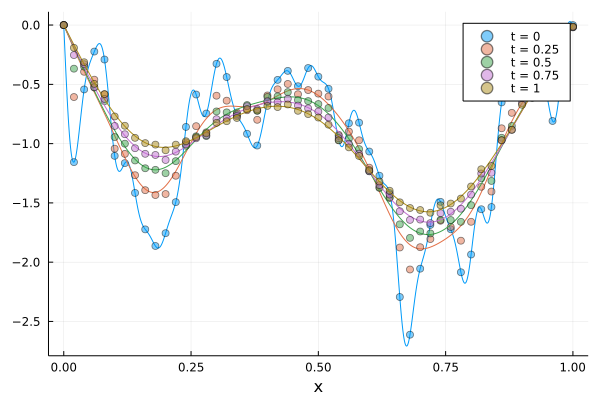

In [34]:
ploterr(A_ℓ₂, u[1])

Let us compare the resulting matrices:

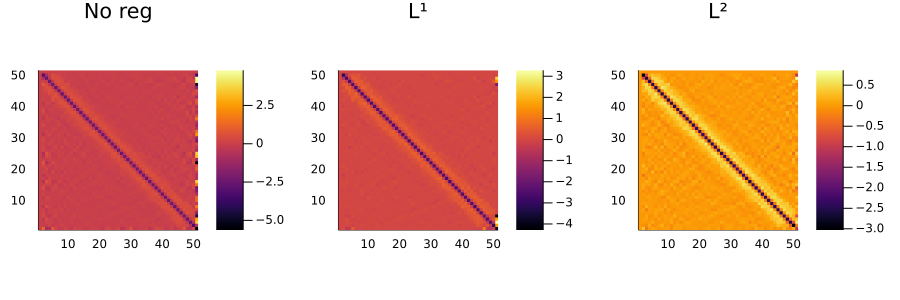

In [35]:
plot(
    plotmat(Afit; title = "No reg"),
    plotmat(A_ℓ₁; title = "L¹"),
    plotmat(A_ℓ₂; title = "L²");
    layout = (1, 3),
    size = (900, 300),
)

Indeed, the $L^1$-regularized matrix is sparser.

## Non-intrusive operator inference

It is also possible to infer the operator $\mathbf{A}$ without ever computing the gradient
of $\mathbf{S}$, using snapshot matrices only. Consider the above defined snapshot matrix
$\mathbf{U}$ as well as its left hand side equivalent $\dot{\mathbf{U}}$ (containing
snapshots of the time derivatives $\frac{\mathrm{d} \mathbf{u}}{\mathrm{d} t}(t_k)$). The
operator that best satisfies the original ODE at the snapshots of interest should be the
solution to the following minimization problem:

$$\underset{\mathbf{A} \in \mathbb{R}^{N \times N}}{\min} \ell(\mathbf{A}),$$

where $\ell$ is some performance metric, typically consisting of a data fitting term
$\ell_\text{data}(\mathbf{A}) = \| \mathbf{A} \mathbf{U} - \dot{\mathbf{U}} \|_F^2$, where
$\| \mathbf{X} \|_F = \sqrt{\sum_{i j} X_{i j}^2}$ is the Frobenius norm (we could use any
discrete norm here). We would also like to add a regularization term $\ell_\text{reg}$ to
enforce some expected behavior on the operator. Since the first and last component of the
solution vector $\mathbf{u}$ are zero (because of the boundary conditions), the first and
last columns of $\mathbf{A}$ do not affect the value of $\ell_\text{data}$. An
$L^2$-regularization $\ell_\text{reg}(\mathbf{A}) = \lambda \| \mathbf{A} \|_F^2$ simply
incites these two columns to take the value zero.

The solution in the case of an $L^2$-regularization is given by

$$\mathbf{A} = \underset{\mathbf{A} \in \mathbb{R}^{N \times N}}{\operatorname{argmin}} \|
\mathbf{A} \mathbf{U} - \dot{\mathbf{U}} \|_F^2 + \lambda \| \mathbf{A} \|_F^2 =
\dot{\mathbf{U}} \mathbf{U}^\mathsf{T} (\mathbf{U} \mathbf{U}^\mathsf{T} + \lambda
\mathbf{I})^{-1}.$$

Information from one single solution may not fully describe the dynamics of other
solutions, as they may contain different frequencies. We may build an augmented snapshot
matrix by concatenating snapshot matrices for many different initial conditions. Here we
will use the exact solutions, but we could also have used the approximations as above.

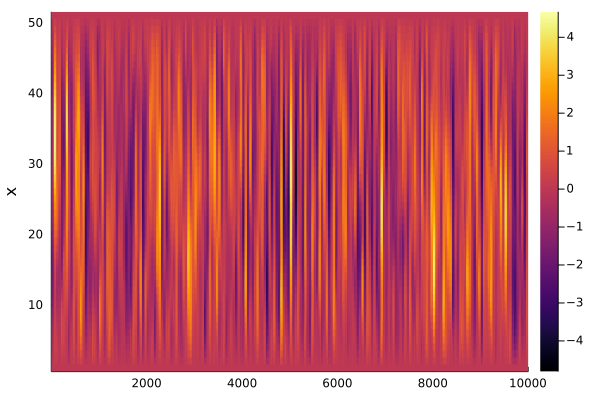

In [37]:
U = reshape(train, N + 1, :)
∂U∂t = reshape(∂train∂t, N + 1, :)

plotmat(reshape(permutedims(train, (1, 3, 2)), N + 1, :); aspect_ratio = :none, ylabel = "x")

We may zoom in on the first five solutions;

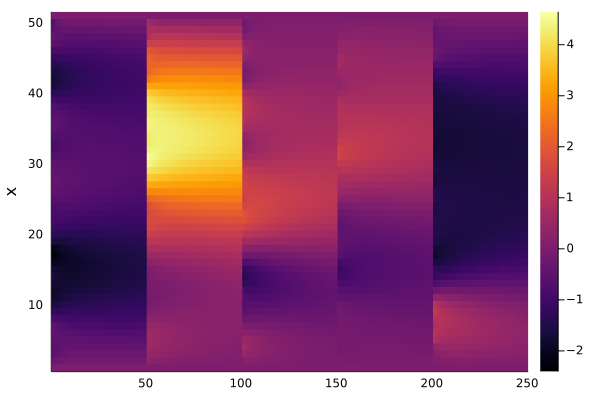

In [38]:
plotmat(
    reshape(permutedims(train, (1, 3, 2)), N + 1, :)[:, 1:(5 * length(tsnap))];
    aspect_ratio = :none,
    ylabel = "x",
)

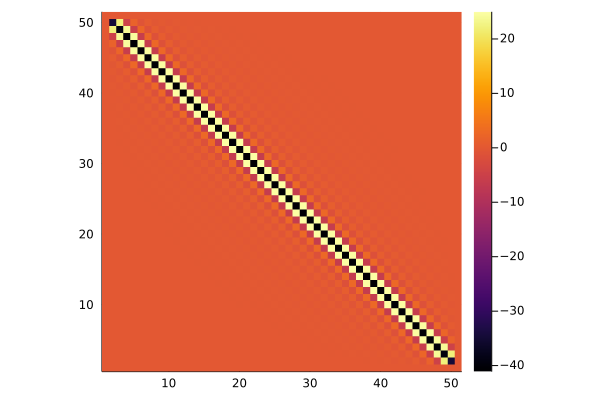

In [39]:
A_ls = ∂U∂t * U' / (U * U' + 1e-8I)
plotmat(A_ls)

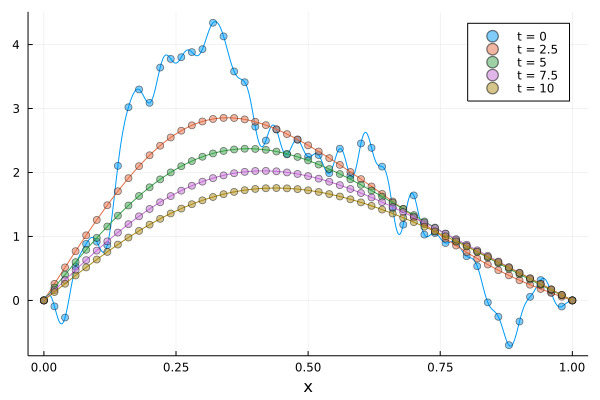

In [40]:
ploterr(A_ls, u[7], LinRange(0.0, 10.0, 5))

# Proper orthogonal decomposition (POD)

Above we learned the discrete diffusion operator in the canonical basis of
$\mathbb{R}^N$. Another useful basis is obtained from a *proper orthogonal
decomposition* (POD). It is determined from snapshot data of the solution at
different time steps (`tsnap`) and possibly different initial conditions.
Truncating this basis at a level $P \ll N$ will yield *the* basis of size $P$
with the smallest error energy for the training data (among all possibile
bases spanning $P$-dimensional subspaces of $L^2(\Omega)$).

The POD basis is simply just a collection of left singular vectors of our snapshot matrix
$\mathbf{U}$. We will keep the $P$ first basis functions (they are the most important, as
`svd` orders them by decreasing singular value). The basis functions will be stored as
columns in the matrix $\mathbf{\Phi} \in \mathbb{R}^{N \times P}$.

In [41]:
P = 20
decomp = svd(U)
Φ = decomp.U[:, 1:P]

51×20 Matrix{Float64}:
 1.11e-16    2.776e-17  -1.665e-16  …   2.227e-15   9.718e-15   3.678e-16
 0.01084     0.02038    -0.03404        0.1397     -0.1709      0.01522
 0.02142     0.0411     -0.06645        0.1482     -0.1096     -0.03282
 0.03192     0.0622     -0.09679       -0.02769     0.1101     -0.07433
 0.04239     0.08387    -0.1239        -0.186       0.1858      0.01583
 0.05274     0.106      -0.1457     …  -0.1244      0.01506     0.1184
 0.063       0.1276     -0.1625         0.1022     -0.1538      0.004944
 0.07347     0.1478     -0.1754         0.2088     -0.1286     -0.1266
 0.08438     0.1658     -0.1838         0.05733     0.04233    -0.02217
 0.09559     0.1804     -0.187         -0.1692      0.1434      0.1227
 0.1067      0.1912     -0.1848     …  -0.2126      0.08017     0.09927
 0.1175      0.1982     -0.1764         0.003853   -0.07065    -0.09759
 0.1282      0.2013     -0.1618         0.2336     -0.1242     -0.192
 ⋮                                  ⋱      

We may plot some POD modes.

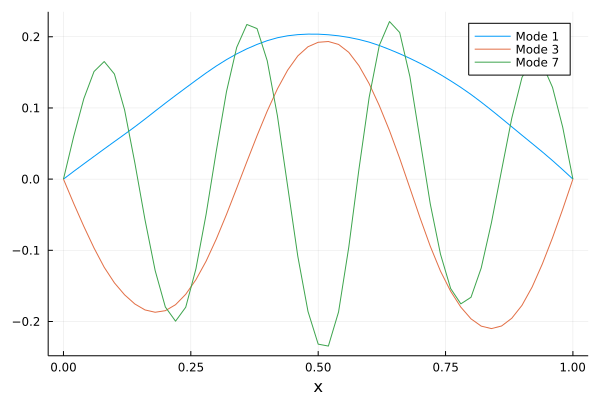

In [42]:
p = plot(; xlabel = "x");
i = 0
for k ∈ [1, 3, 7]
    i += 1
    plot!(p, x, Φ[:, k]; label = "Mode $k", color = i)
    # plot!(p, x, X.(k, x); label = "k = $k", color = i)
    # plot!(p, x, XK[:, k]; label = nothing, linestyle = :dash, color = i)
end
p

We may check the orthogonality by computing the inner product between each basis function
pair.

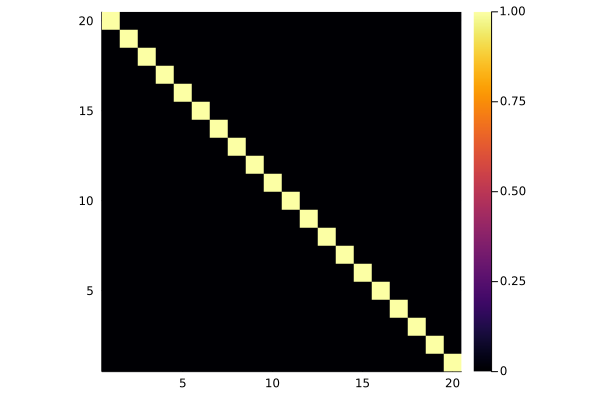

In [43]:
plotmat(Φ'Φ)

The matrix $\mathbf{Φ} \mathbf{Φ}^\mathsf{T}$ can be considered to be a so called
"autoencoder", with "encoder" $\mathbf{Φ}^\mathsf{T}$ and "decoder" $\mathbf{Φ}$. The
autoencoder should be closer to identity when keeping more modes, i.e. we may be tempted
to write something like $\mathbf{Φ} \mathbf{Φ}^\mathsf{T} \underset{P \to N}{\to}
\mathbf{I}$ (by abuse of mathematical notation).

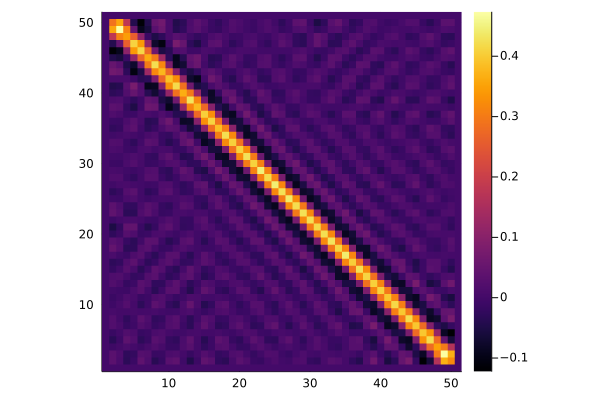

In [44]:
plotmat(Φ * Φ')

Projecting the full order model onto the POD basis yields the reduced order model

$$\frac{\mathrm{d} \tilde{\mathbf{u}}}{\mathrm{d} t} = \tilde{\mathbf{A}}
\tilde{\mathbf{u}},$$

where $\tilde{\mathbf{u}}$ are the coordinates of the ROM solution in the POD basis and
$\tilde{\mathbf{A}} = \mathbf{\Phi}^\mathsf{T} \mathbf{A} \mathbf{\Phi} \in \mathbb{R}^{P
\times P}$ is the reduced order operator. Later, we will try to infer this operator
directly from data. Note that the ROM solution is given by $\mathbf{u}_\text{ROM} =
\mathbf{\Phi} \tilde{\mathbf{u}}$.

Note also that the FOM and ROM have the same form, just different sizes (and "tilde"s
appearing everywhere). The ROM solution may thus simply be computed by

$$\mathbf{u}_\text{ROM}(t) = \mathbf{\Phi} \mathbf{S}(\tilde{\mathbf{A}},
\mathbf{\Phi}^\mathsf{T} \mathbf{u}_0, t).$$

In [45]:
S_POD(A_pod, u₀, t) = Φ * S(A_pod, Φ'u₀, t)

S_POD (generic function with 1 method)

Let us compare the solution of the ROM and FOM:

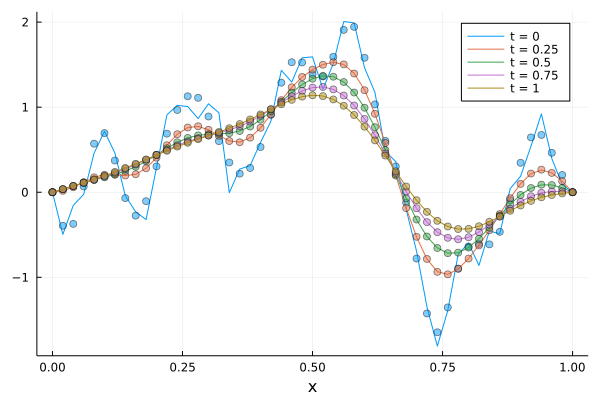

In [47]:
tplot = LinRange(0.0, 1.0, 5)
sample = 3
sol = S(A_ref, u[sample].(x, 0.0), tplot)
sol_pod = S_POD(Φ' * A_ref * Φ, u[sample].(x, 0.0), tplot)
p = plot(; xlabel = "x");
for (i, t) ∈ enumerate(tplot)
    # scatter!(p, x, u.(x, t); label = nothing, markeralpha = 0.5, color = i) # Exact
    plot!(p, x, sol[i]; label = "t = $t", color = i) # FOM
    scatter!(p, x, sol_pod[:, i]; label = nothing, markeralpha = 0.5, color = i) # ROM
end
p

Try using fewer modes and see what happens!

## Learning the operator in the POD basis

Similarly to the full order model case, we may fit the POD operator
$\tilde{A}$ using intrusive and non-intrusive approaches.

### Non-intrusive approach

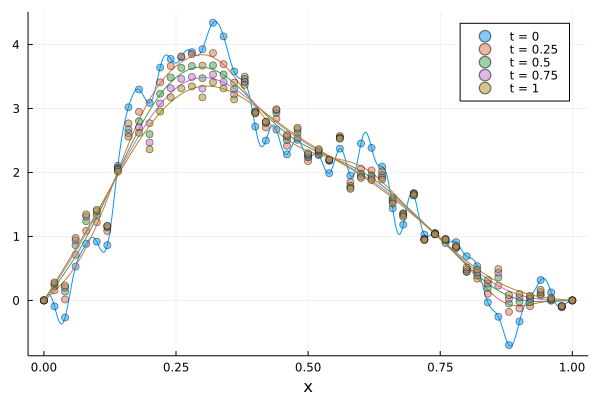

In [48]:
V = Φ'U
∂V∂t = Φ'∂U∂t

A_POD_ls = ∂V∂t * V' / (V * V' + 1e-8I)
plotmat(A_POD_ls)
plotmat(Φ * A_POD_ls * Φ')
ploterr(Φ * A_POD_ls * Φ', u[7], LinRange(0.0, 1.0, 5))

### Intrusive approach

First we need to create snapshot tensors of the POD solutions/observations:

In [49]:
init_POD = Φ'init
train_POD = zeros(P, nsample, length(tsnap))
for i ∈ eachindex(tsnap)
    train_POD[:, :, i] = Φ' * train[:, :, i]
end

We may also reuse the loss function and ODE solver from the full order case
(only the sizes change).

In [50]:
loss_POD(A_POD) = loss(A_POD, init_POD, train_POD, tsnap)

result = DiffEqFlux.sciml_train(
    loss_POD,
    zeros(P, P),
    ADAM(0.01);
    cb = (A, l) -> callback(Φ * A * Φ', l),
    maxiters = 1000,
)

A_POD_fit = result.u

0.2691
0.2595
0.2521
0.2457
0.2403
0.2352
0.2303
0.2258
0.2214
0.2172
0.213
0.2088
0.2048
0.2008
0.197
0.1934
0.1898
0.1864
0.1831
0.1799
0.1769
0.1739
0.171
0.1682
0.1655
0.1629
0.1603
0.1578
0.1553
0.1529
0.1506
0.1483
0.1461
0.144
0.1419
0.1398
0.1379
0.1359
0.134
0.1322
0.1303
0.1286
0.1268
0.1252
0.1235
0.1219
0.1203
0.1188
0.1173
0.1159
0.1144
0.113
0.1117
0.1103
0.1091
0.1078
0.1065
0.1053
0.1042
0.103
0.1019
0.1008
0.09968
0.09862
0.09758
0.09657
0.09557
0.09459
0.09364
0.0927
0.09178
0.09088
0.08999
0.08912
0.08827
0.08743
0.08661
0.0858
0.08501
0.08423
0.08347
0.08271
0.08198
0.08125
0.08054
0.07983
0.07914
0.07846
0.0778
0.07714
0.07649
0.07586
0.07523
0.07461
0.07401
0.07341
0.07282
0.07224
0.07167
0.0711
0.07055
0.07
0.06946
0.06893
0.0684
0.06789
0.06738
0.06688
0.06638
0.06589
0.06541
0.06493
0.06446
0.064
0.06354
0.06309
0.06265
0.06221
0.06177
0.06134
0.06092
0.0605
0.06009
0.05968
0.05928
0.05888
0.05849
0.0581
0.05772
0.05734
0.05697
0.0566
0.05623
0.05587
0.05551
0.

20×20 Matrix{Float64}:
 -0.04991    0.002524   -0.008713  …   0.0004856   0.0004304   0.002068
  0.002525  -0.1991     -0.004878      0.001069    0.0008376   0.003355
 -0.008703  -0.004872   -0.4479        0.001425   -0.008843   -0.002473
  0.01257    0.009102   -0.03035      -0.00792     0.009357   -0.003254
 -0.004218   0.004107    0.008933      0.006177    0.008196   -0.01166
 -0.002395   0.02933    -0.008783  …   0.005484   -0.01112    -0.01441
 -0.004792  -0.003261   -0.01014       0.03994    -0.08734     0.03007
  0.004303  -0.04609    -0.0108        0.05282    -0.1118     -0.1574
 -0.001933   0.006104    0.04967      -0.169       0.4499     -0.5269
 -0.002119  -0.01558     0.01433      -0.2856      0.6548      0.6175
 -0.01071   -0.01589     0.001312  …  -0.05444     0.5066      0.4825
  0.004529   0.01249     0.02411      -0.04847     0.6042     -1.049
  0.003704   0.00864     0.008315      0.145      -0.4396      0.6247
 -0.002491  -0.002774   -0.007184      0.06851     0.1934

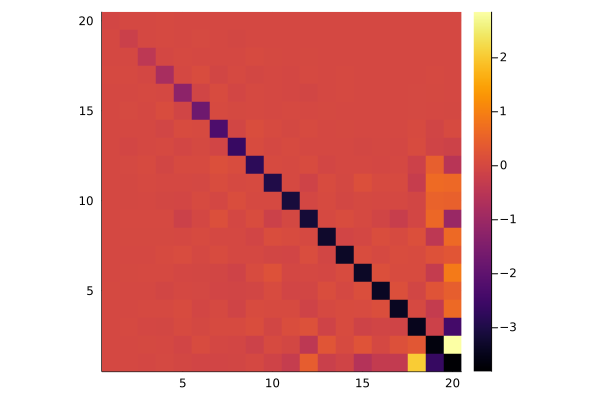

In [51]:
plotmat(A_POD_fit)

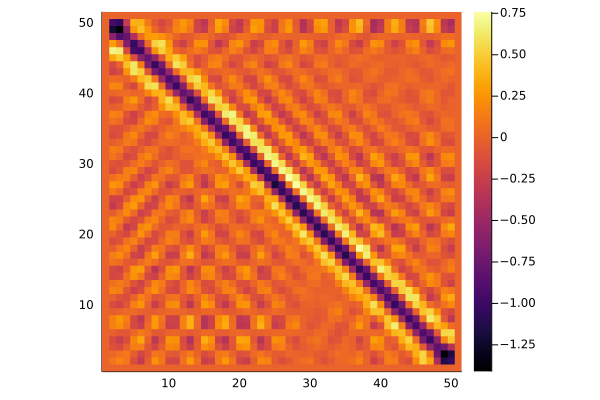

In [52]:
plotmat(Φ * A_POD_fit * Φ')

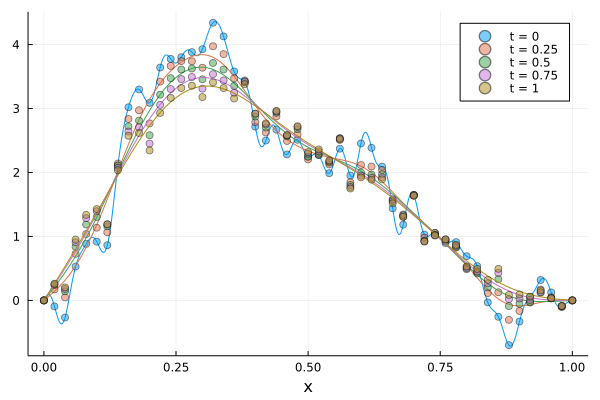

In [53]:
ploterr(Φ * A_POD_fit * Φ', u[7], LinRange(0.0, 1.0, 5))

## Learning the operator in the eigenfunction basis

In the continuous eigenfunction basis $(X_k)_k$, the continuous diffusion
operator is an infinite diagonal matrix. Projecting the solution on to a
truncated eigenfunction basis would thus result in a finite diagonal matrix.

### Non-intrusive approach

In [54]:
K_eig = 20
XK = √Δx .* X.((1:K_eig)', x)

51×20 Matrix{Float64}:
 0           0          0          …   0           0           0
 0.01256     0.02507    0.03748        0.181       0.186       0.1902
 0.02507     0.04974    0.07362        0.1541      0.1369      0.1176
 0.03748     0.07362    0.1072        -0.04974    -0.08516    -0.1176
 0.04974     0.09635    0.1369        -0.1965     -0.1996     -0.1902
 0.0618      0.1176     0.1618     …  -0.1176     -0.0618     -4.899e-17
 0.07362     0.1369     0.181          0.09635     0.1541      0.1902
 0.08516     0.1541     0.1937         0.1996      0.1753      0.1176
 0.09635     0.1689     0.1996         0.07362    -0.02507    -0.1176
 0.1072      0.181      0.1984        -0.1369     -0.1937     -0.1902
 0.1176      0.1902     0.1902     …  -0.1902     -0.1176     -9.797e-17
 0.1275      0.1965     0.1753        -0.02507     0.1072      0.1902
 0.1369      0.1996     0.1541         0.1689      0.1965      0.1176
 ⋮                                 ⋱                          
 0.

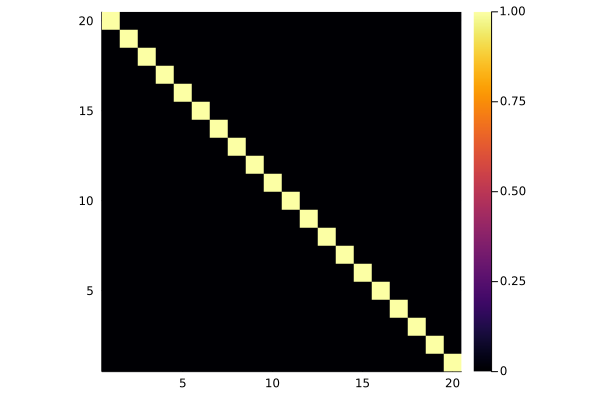

In [57]:
plotmat(XK'XK)

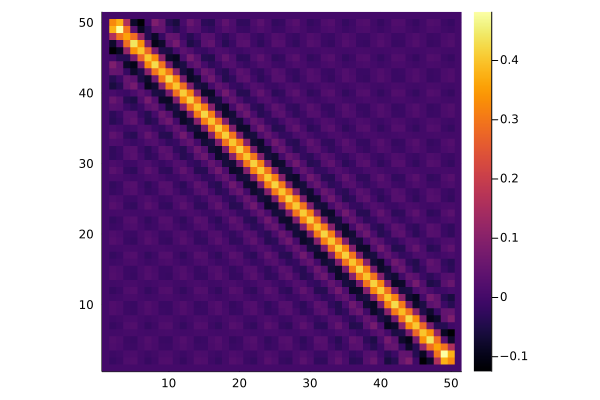

In [59]:
plotmat(XK * XK')

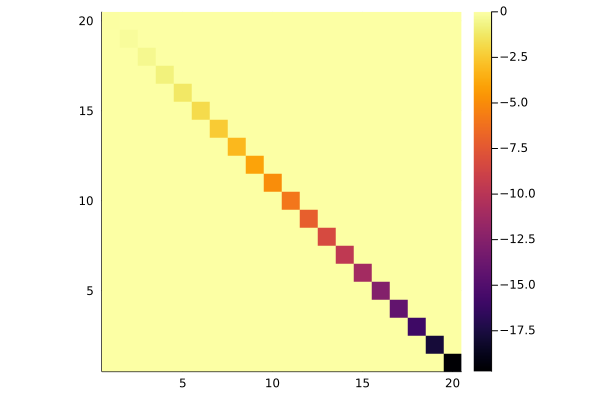

In [60]:
W = XK'U
∂W∂t = XK'∂U∂t

A_eig_ls = ∂W∂t * W' / (W * W' + 1e-8I)
plotmat(A_eig_ls)

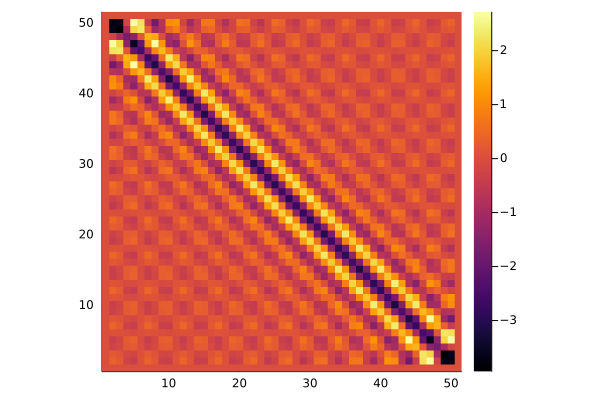

In [61]:
plotmat(XK * A_eig_ls * XK')

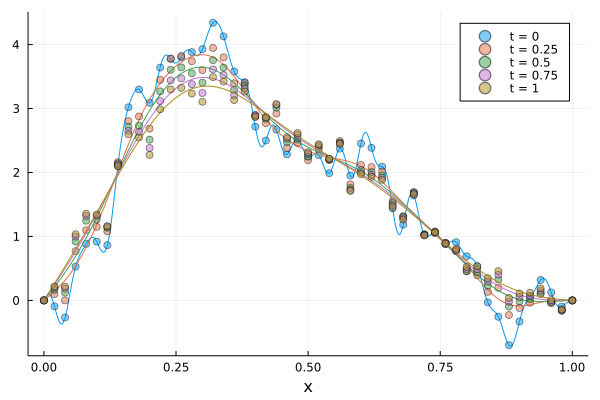

In [63]:
ploterr(XK * A_eig_ls * XK', u[7], LinRange(0.0, 1.0, 5))

### Intrusive approach

In [64]:
init_eig = XK'init
train_eig = zeros(P, nsample, length(tsnap))
for i ∈ eachindex(tsnap)
    train_eig[:, :, i] = XK' * train[:, :, i]
end

In [65]:
loss_eig(A) = loss(A, init_eig, train_eig, tsnap)

loss_eig (generic function with 1 method)

In [66]:
result = DiffEqFlux.sciml_train(
    loss_eig,
    zeros(K_eig, K_eig),
    ADAM(0.01);
    cb = (A, l) -> callback(XK * A * XK', l),
    maxiters = 1000,
)
A_eig_fit = result.u

0.2657
0.2557
0.2475
0.241
0.2353
0.23
0.225
0.2205
0.2163
0.2122
0.208
0.2039
0.1999
0.196
0.1923
0.1887
0.1852
0.1818
0.1785
0.1754
0.1724
0.1695
0.1666
0.1639
0.1612
0.1586
0.156
0.1536
0.1512
0.1488
0.1465
0.1443
0.1421
0.14
0.138
0.136
0.134
0.1321
0.1303
0.1285
0.1267
0.125
0.1233
0.1216
0.12
0.1184
0.1169
0.1154
0.114
0.1125
0.1111
0.1098
0.1085
0.1072
0.1059
0.1047
0.1035
0.1023
0.1011
0.1
0.0989
0.09782
0.09677
0.09574
0.09473
0.09374
0.09277
0.09182
0.09089
0.08998
0.08908
0.08821
0.08735
0.0865
0.08568
0.08487
0.08407
0.08329
0.08252
0.08176
0.08102
0.0803
0.07958
0.07888
0.07819
0.07751
0.07684
0.07619
0.07554
0.07491
0.07428
0.07367
0.07306
0.07246
0.07188
0.0713
0.07073
0.07017
0.06962
0.06907
0.06854
0.06801
0.06749
0.06698
0.06647
0.06597
0.06548
0.065
0.06452
0.06404
0.06358
0.06312
0.06267
0.06222
0.06178
0.06134
0.06091
0.06049
0.06007
0.05965
0.05925
0.05884
0.05844
0.05805
0.05766
0.05728
0.0569
0.05652
0.05615
0.05579
0.05543
0.05507
0.05472
0.05437
0.05402
0.0536

20×20 Matrix{Float64}:
 -0.04936    -5.118e-06  -2.928e-06  …  -0.0002063  -0.0005498   0.0001092
 -5.576e-06  -0.1974      1.241e-05     -0.0009443   0.0003425  -4.529e-05
 -3.77e-06    1.423e-05  -0.4443        -0.0008455  -0.003525    0.0006483
  1.548e-06  -1.524e-05   3.904e-06      0.005023    0.001323    0.001549
  9.378e-06  -7.059e-05   0.0001612      0.0001621   0.01349     0.01807
  7.302e-05   0.0001695   0.0001541  …  -0.004395    0.01721    -0.008469
 -0.0003934  -1.874e-05  -0.0001875      0.0004311  -0.002342   -0.004541
 -0.0003394   0.008552   -0.0004848     -0.01005     0.01628    -0.118
 -0.001681    0.003464   -0.02137        0.2134     -0.6151     -0.2109
  0.0008929   0.006801    0.004462       0.05351     0.08252     0.8688
 -0.005667   -0.00667    -0.001768   …   0.4954     -0.442      -0.6685
  0.001836    0.007798   -0.012          0.528      -0.9015     -0.6267
 -0.003311   -0.004924    0.001592       0.09852    -0.693      -0.006035
  0.0002448  -0.0001842 

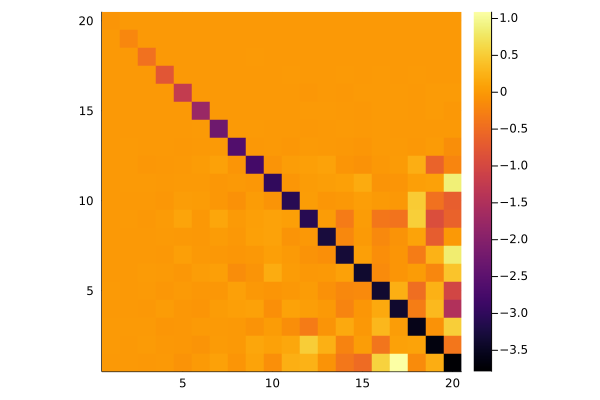

In [69]:
plotmat(A_eig_fit)

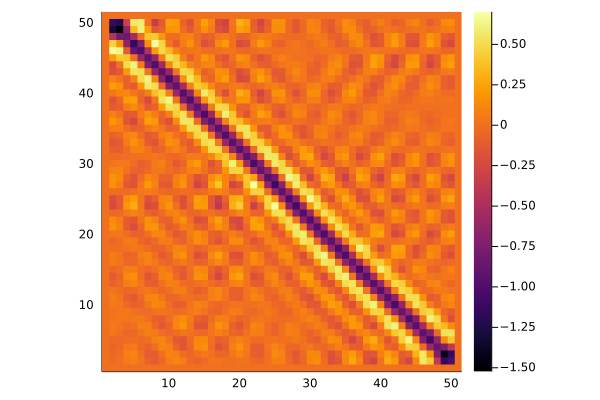

In [70]:
plotmat(XK * A_eig_fit * XK')

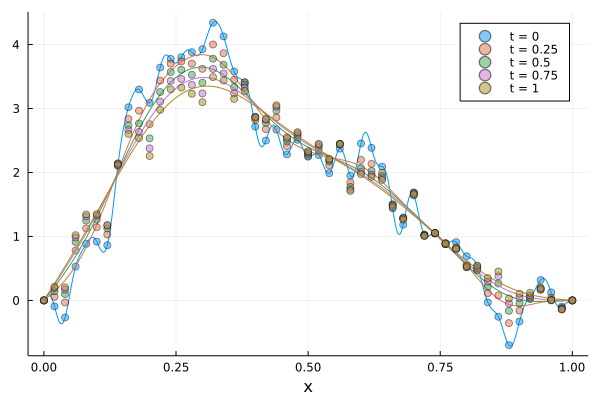

In [73]:
ploterr(XK * A_eig_fit * XK', u[7], LinRange(0.0, 1.0, 5))

## Summary

In this example, we considered a uniformly discretized diffusion equation
with homogeneous Dirichlet boundary conditions for three discrete functional
bases:

* the canonical basis of $\mathbb{R}^N$: $\mathbf{I} = (\mathbf{e}_n)_n \in
  \mathbb{R}^{N \times N}$
* the eigenfunction basis of $\frac{\partial^2}{\partial x^2}$: $\mathbf{X} =
  (X_k(\mathbf{x}))_k \in \mathbb{R}^{N \times K}$, $K \ll N$
* the POD basis $\mathbf{\Phi} = (\mathbf{\phi}_p)_p \in \mathbb{R}^{N \times
  P}$, $P \ll N$

where the diffusion operator $\frac{\partial^2}{\partial x^2}$ was
represented by $\mathbf{A}$, $\bar{\mathbf{A}}$, and $\tilde{\mathbf{A}}$
respectively. These three operators, of respective sizes $N \times N$, $K
\times K$, and $P \times P$, were then inferred using two methods:

* intrusive inference, where the ODE-solver $\mathbf{S}$ needs to be available and
  differentiable, and the operator is trained using gradient descent;
* non-intrusive inference, using snapshot matrices only.

For this simple test case, the latter option seems to work well. However, for
nonlinear equations where the differential operator is nonlinear, a simple
least squares fit will not do. Having access to differentiable ODE solver
opens up a new world.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*